In [1]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sqlalchemy import create_engine
from mpl_toolkits.mplot3d import Axes3D

def _load_config(file_path):
    data = {}
    with open(file_path) as f:
        reader = csv.reader(f, skipinitialspace=True, quotechar="'")
        for row in reader:
            data[row[0]] = row[1]
    
    return data

## Configuration

In [2]:
# pycharm cwd is project root dir 
# jupyter cwd is the location of the ipynb

config_path = '.config'
#config_path = '../.config'

data_path = 'data/'
#data_path = '../data/'

plt.rcParams["figure.figsize"] = (15,15)
config = _load_config(config_path)
sql = create_engine(config['postgres_connection_url'])

## Data Load

- unzip raw machine data to data_path
- setup an empty postgres database
- update .config with connection string as needed.
- run storage/postgres.py to import csvs

In [3]:
df = pd.read_sql('''SELECT * from sensor_readings_model1_hourly''',sql)
print(df.shape)
print(df.dtypes)

(325348, 145)
id                     int64
PE_CMD1              float64
PE_CMD2              float64
PE_CMD3              float64
F_CMD1               float64
PERF_C_PR1           float64
C_C_DP1              float64
F_C_DP1              float64
F_C_DP2              float64
F_C_DP3              float64
F_C_DP4              float64
F_C_DP5              float64
LO_C_DT1             float64
LO_C_DT2             float64
LO_C_DT3             float64
LO_C_DT4             float64
LO_C_DT5             float64
LO_C_DT6             float64
C_DT5_1              float64
C_DT5_10             float64
C_DT5_11             float64
C_DT5_12             float64
C_DT5_2              float64
C_DT5_3              float64
C_DT5_4              float64
C_DT5_5              float64
C_DT5_6              float64
C_DT5_1.1            float64
C_DT5_1.2            float64
C_DT5_1.3            float64
                   ...      
T7_5                 float64
T7_6                 float64
T7_7                 float64


In [4]:
index_cols = ['id','TIMESTAMP','PSN']
data_cols = [c for c in df.columns if c not in index_cols]

## Feature Plots

*long running cell*

In [ ]:
def plot_col(df, col):
    fig, ax = plt.subplots()
    for key, grp in df.groupby('PSN'):
        ax = grp.plot(ax=ax, kind='line', x='TIMESTAMP', y=col)

    ax.legend().set_visible(False)
    fig.savefig(data_path + 'feature_plots/model1/'+col+'.png')

for col in data_cols:
    plot_col(df, col)

## Feature Correlation

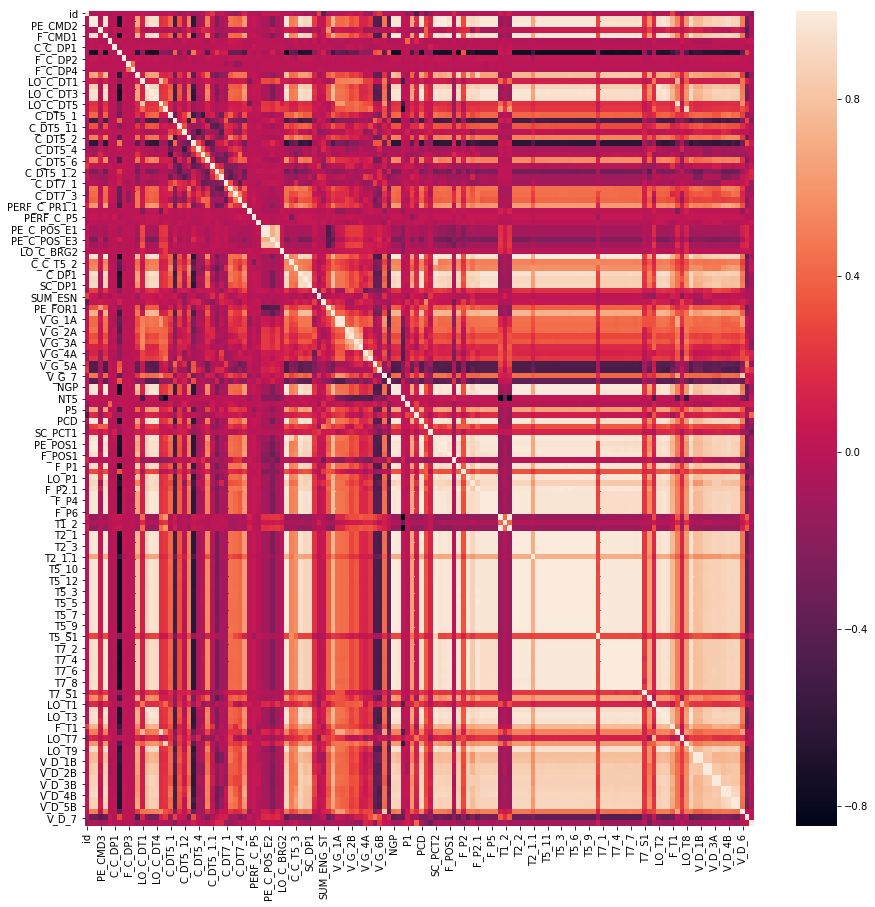

In [43]:
df_corr = df.corr()
sns.heatmap(df_corr)
plt.show()

In [44]:
# https://stackoverflow.com/a/41453817

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print(get_top_abs_correlations(df[data_cols],10))

T2_3  PT2       0.999990
T2_1  PT2       0.999988
T2_2  PT2       0.999986
T2_1  T2_3      0.999969
T2_2  T2_3      0.999964
T2_1  T2_2      0.999961
T7_2  T7_9      0.999933
T7_3  T7_9      0.999925
T5_2  T5_1.1    0.999924
PCD   F_P3      0.999922
dtype: float64


## Missing Values

In [5]:
df_dropna = df.dropna()
missing_values = df.isnull().sum().sort_values()
print('Total Records:',len(df))
print('Complete Records:',len(df_dropna))

print('Missing Values by Col:')
print(missing_values)

Total Records: 325348
Complete Records: 73577
Missing Values by Col:
id                   0
T5_6                 0
T5_5                 0
T5_4                 0
T5_3                 0
T5_2                 0
T5_12                0
T5_11                0
T5_10                0
T5_1                 0
PT2                  0
T2_3                 0
T2_1                 0
T1_3                 0
T1_2                 0
T5_7                 0
F_P6                 0
F_P4                 0
F_P3                 0
F_P2.1               0
LO_P2                0
LO_P1                0
F_P2                 0
F_P1                 0
PE_P1                0
F_POS1               0
PE_POS2              0
PE_POS1              0
C_PCT1               0
TIMESTAMP            0
                 ...  
NGP                  0
PE_FOR1              0
V_G_4B               0
SUM_ENG_ST          46
T2_1.1             200
PE_FOR2            200
T5_8               200
T2_2               200
C_DT5_1.2          200
C_C_T5_3   

In [6]:
sparse_cols = [x for x in missing_values.index[-10:]]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]
df_clean = df[clean_data_cols].dropna()
print('Clean Records:',len(df_clean))

Clean Records: 304500


## PCA

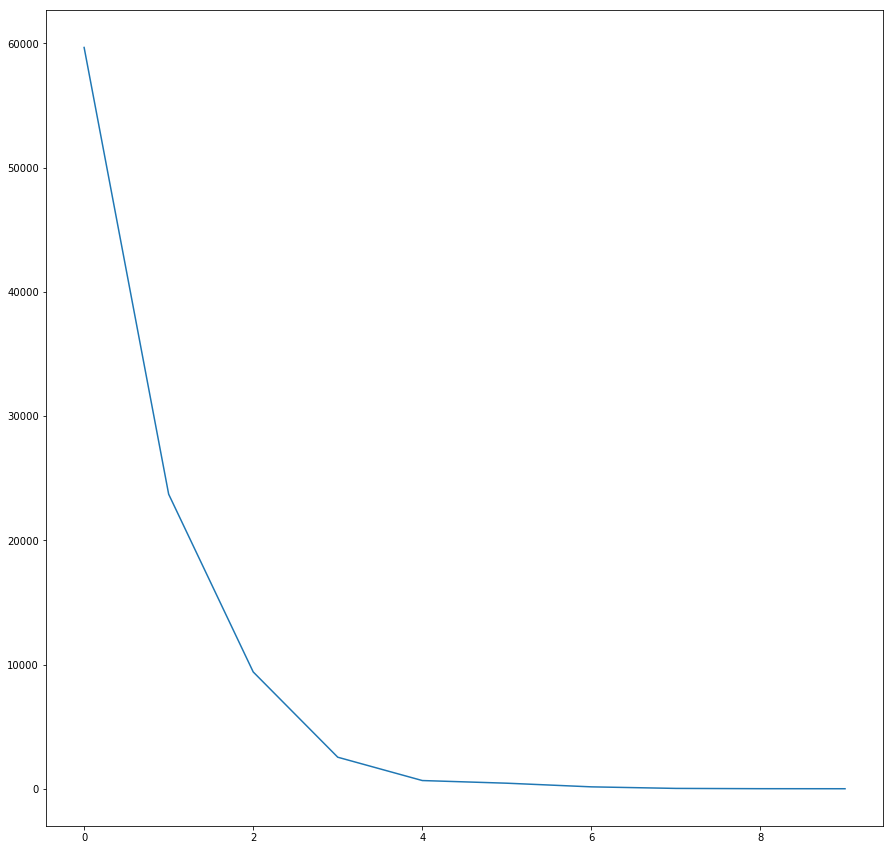

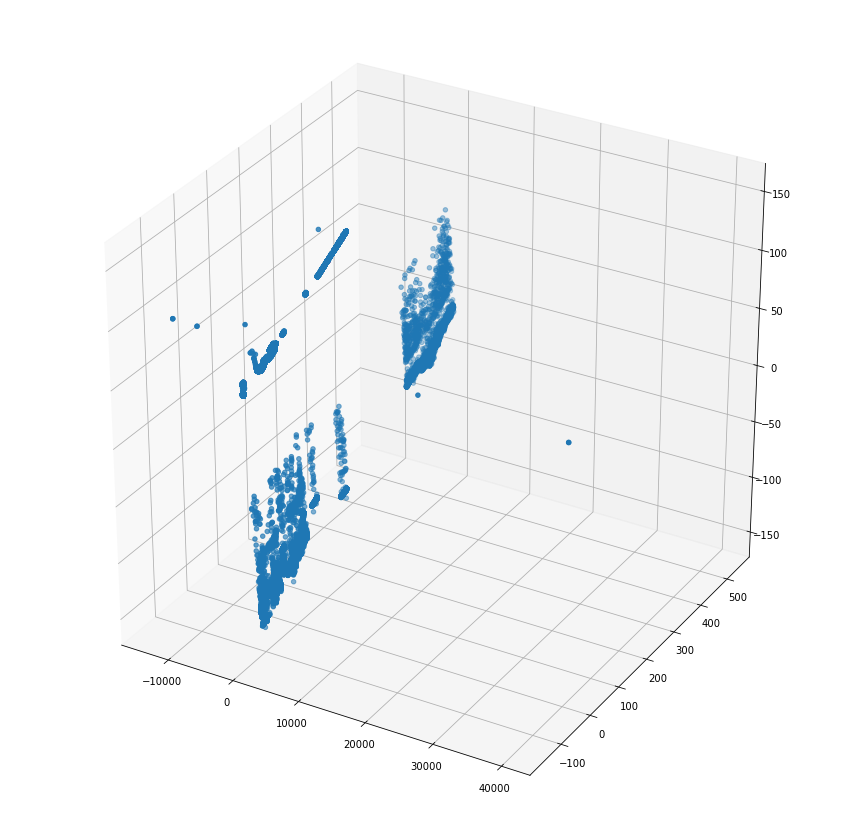

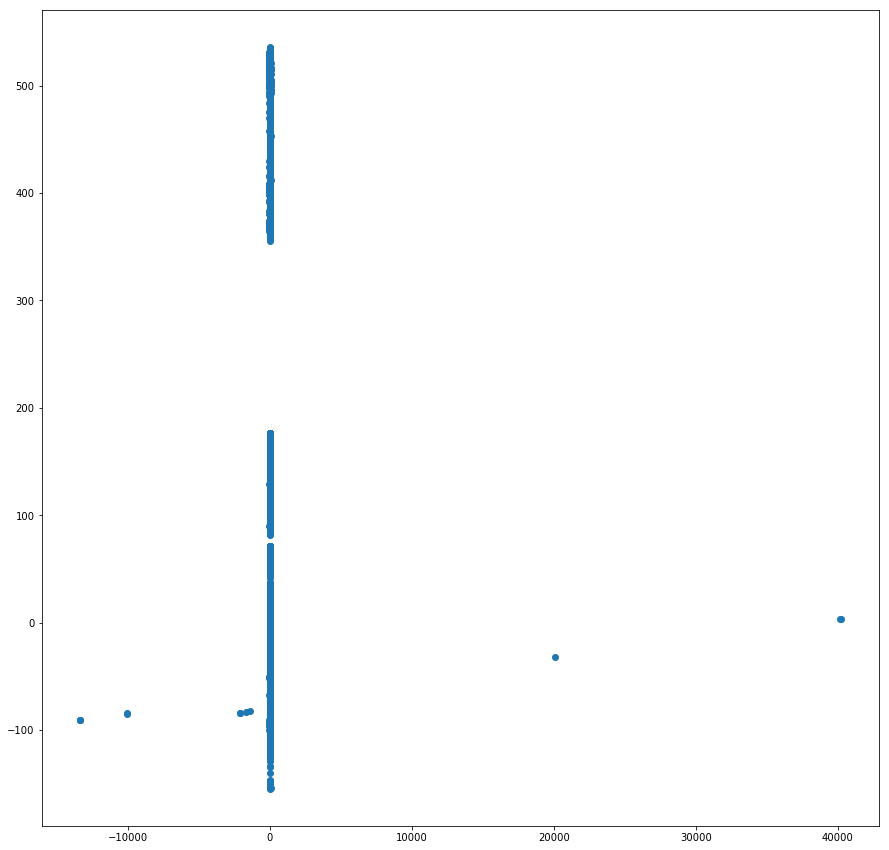

In [13]:
def plot_component_explained_variance(data):
    pca = PCA()
    pca.fit(data)
    
    plt.plot(pca.explained_variance_[:10])
    plt.show()

def plot_3d_reduced(data, colors = None):
    reduced = PCA(n_components=3).fit_transform(data)
    
    x = [r[0] for r in reduced]
    y = [r[1] for r in reduced]
    z = [r[2] for r in reduced]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z, c=colors)
    
    plt.show()
    return reduced

def plot_2d_reduced(data, colors = None):
    reduced = PCA(n_components=2).fit_transform(data)
    
    x = [r[0] for r in reduced]
    y = [r[1] for r in reduced]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x,y, c=colors)
    
    plt.show()
    return reduced

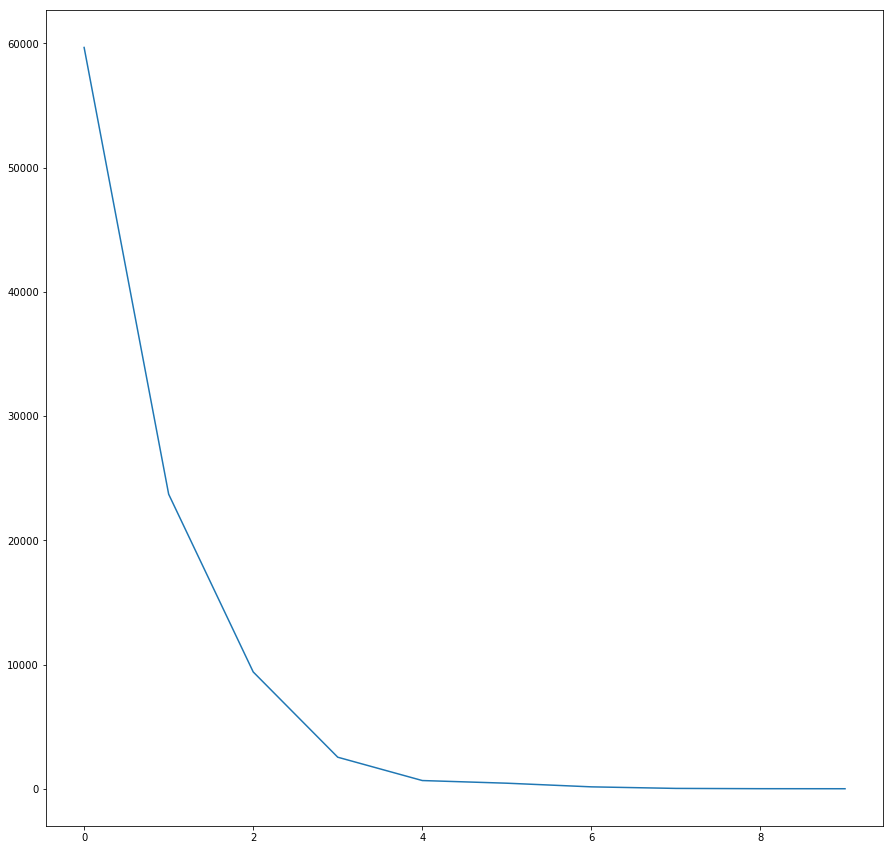

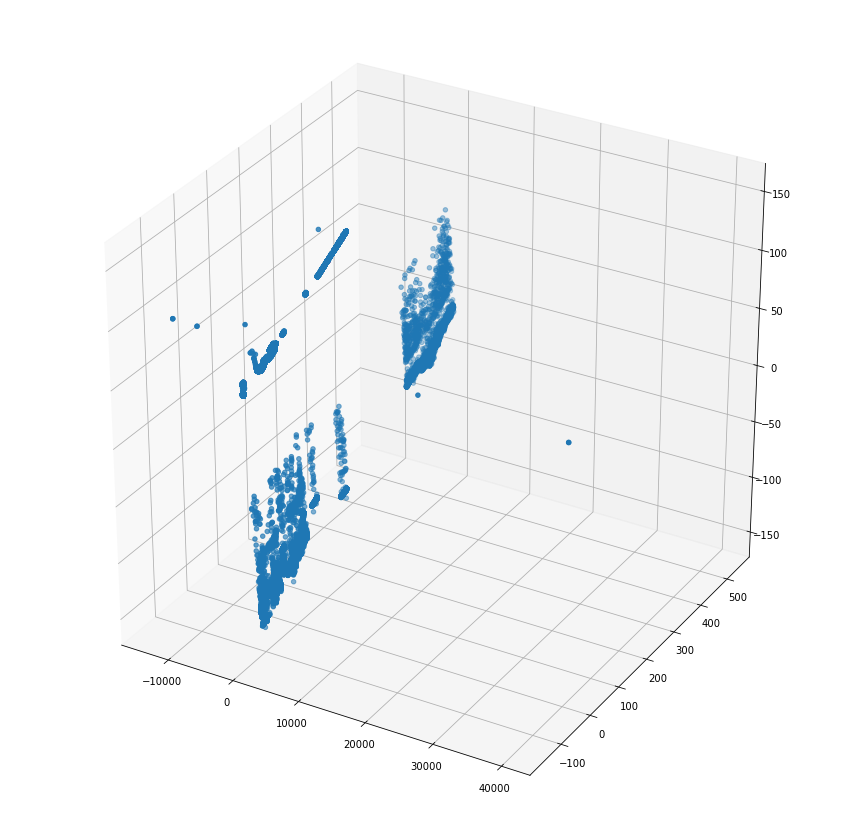

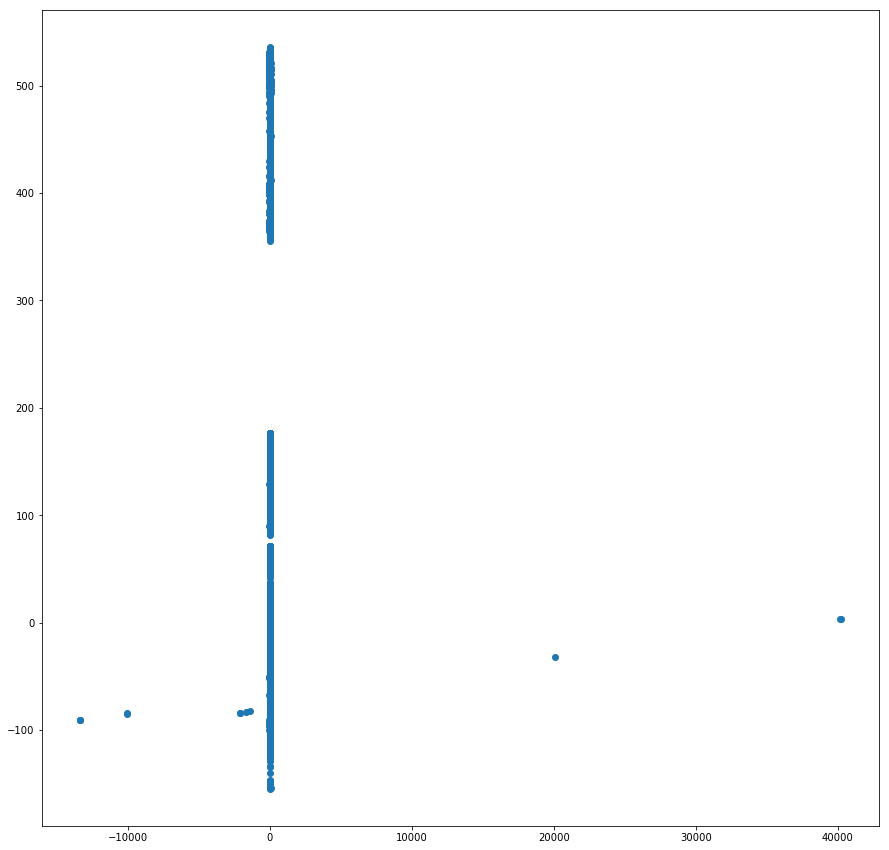

In [14]:
plot_component_explained_variance(df_dropna[data_cols])
reduced_3d_all_data = plot_3d_reduced(df_dropna[data_cols])
reduced_2d_all_data = plot_2d_reduced(df_dropna[data_cols])

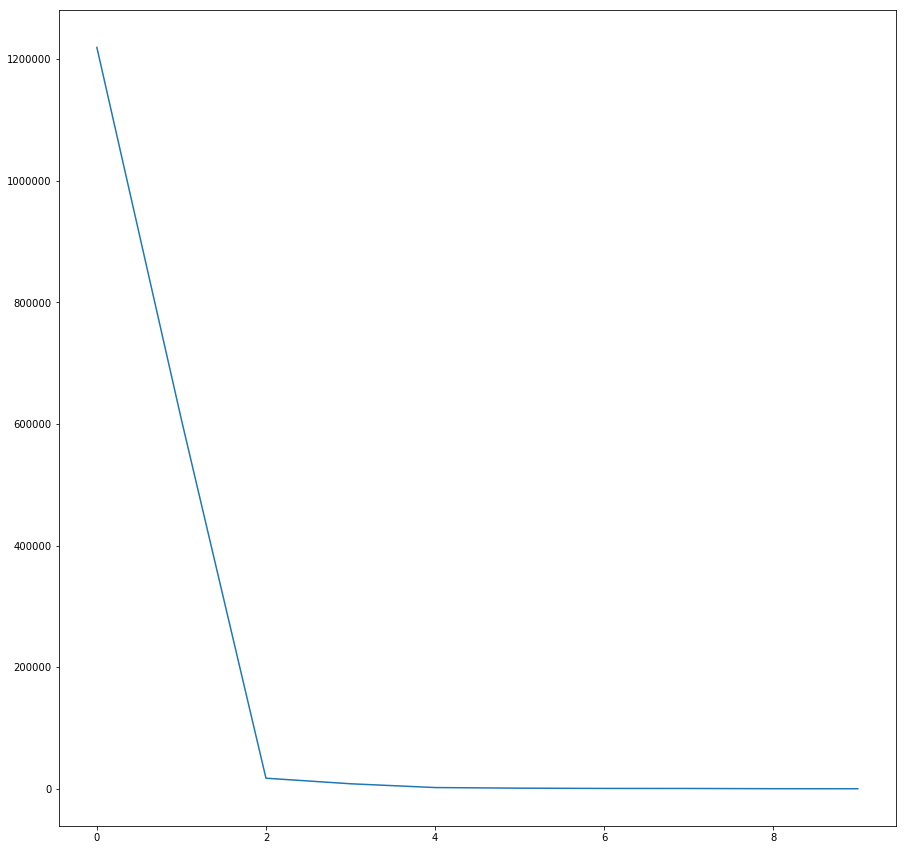

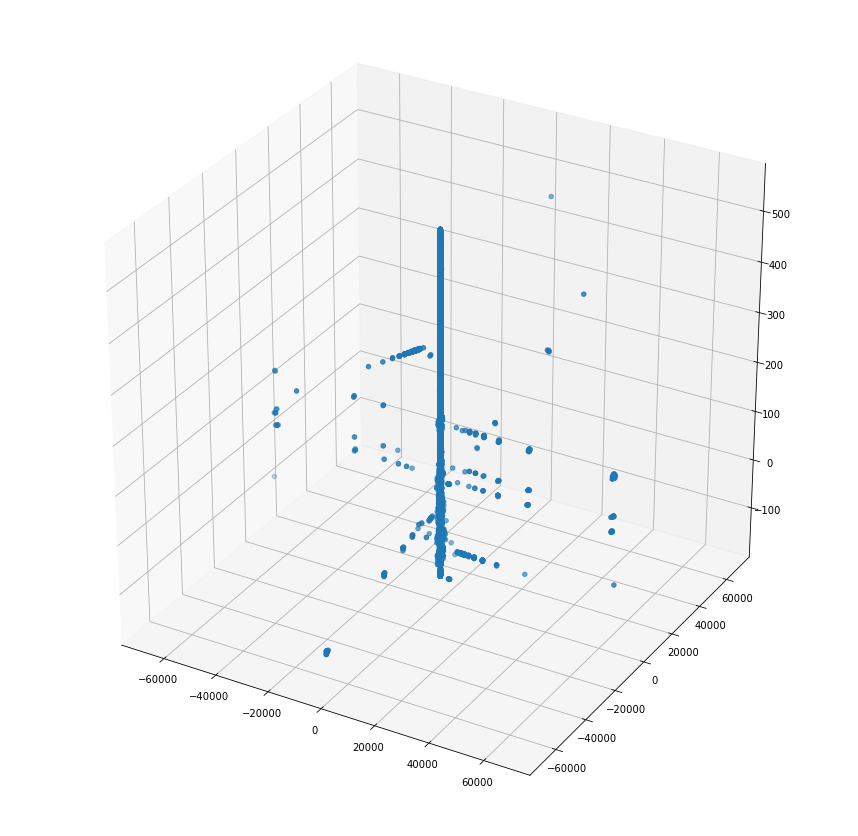

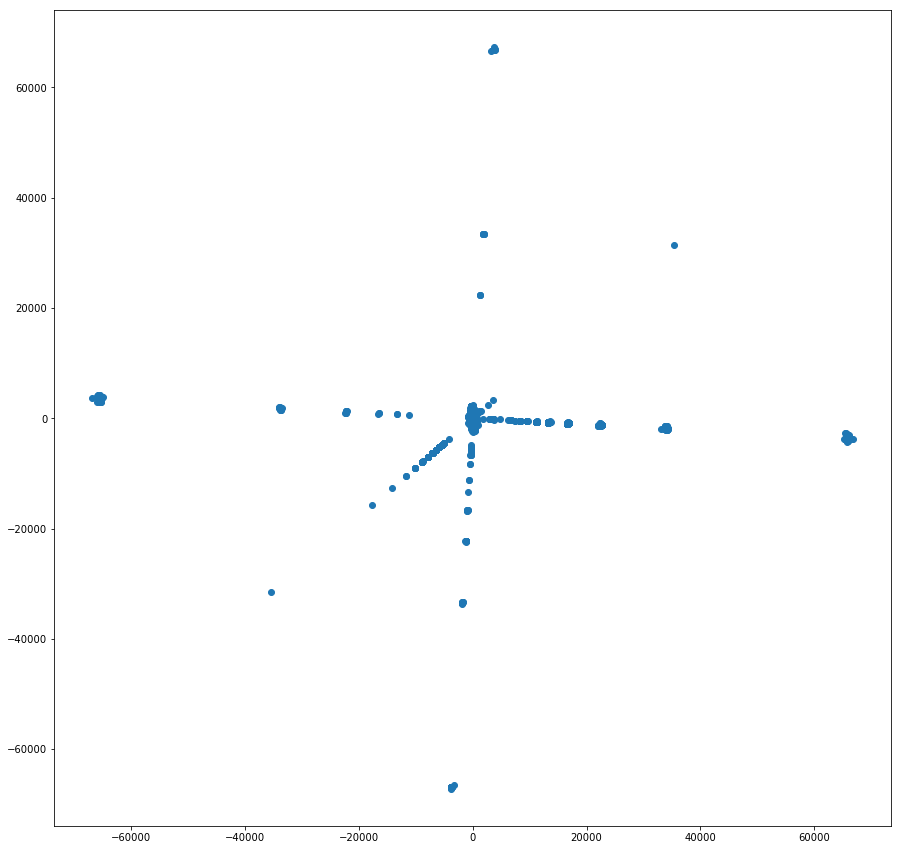

In [17]:
plot_component_explained_variance(df_clean)
reduced_3d_clean_data = plot_3d_reduced(df_clean)
reduced_2d_clean_data = plot_2d_reduced(df_clean)

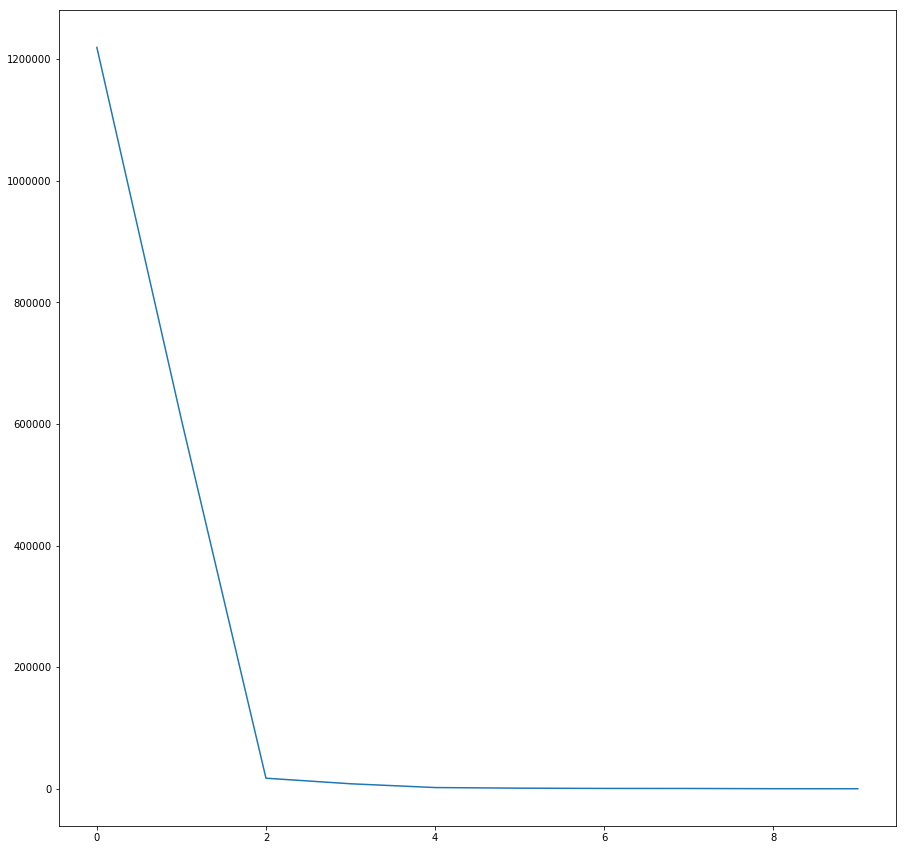

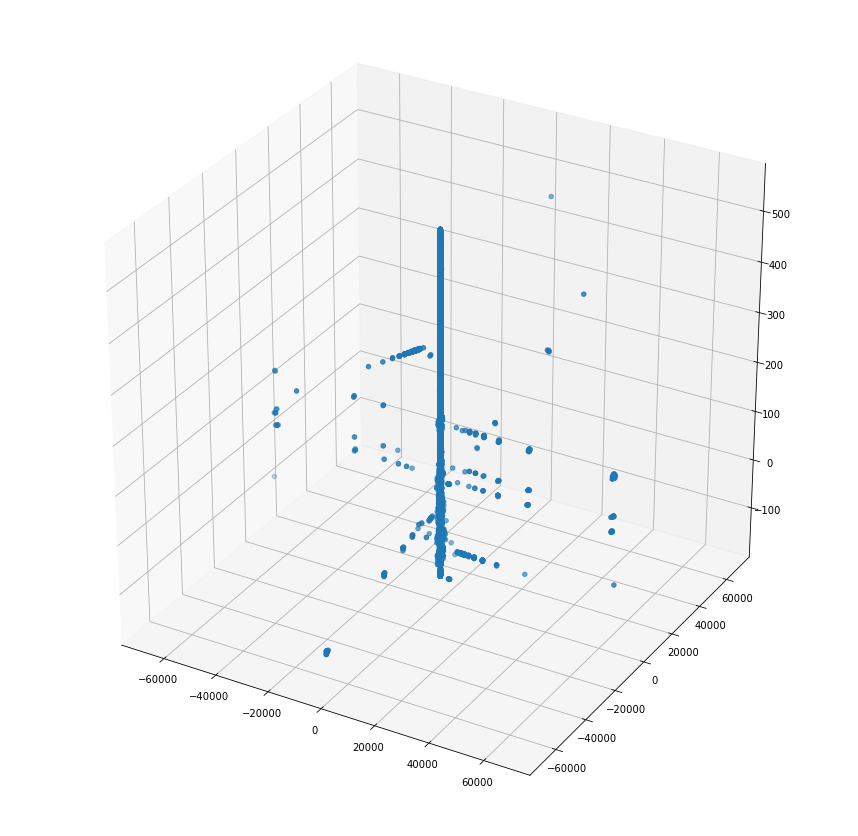

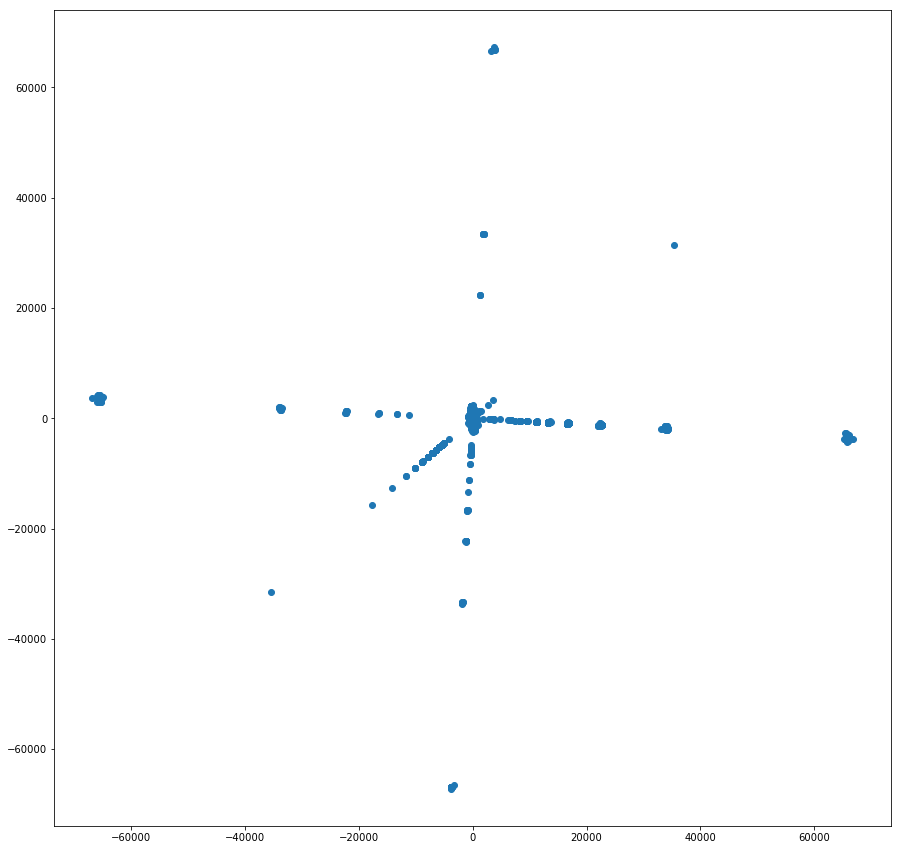

In [18]:
df_interpolate_na = df_clean.interpolate(method='linear', axis=0).ffill().bfill()

plot_component_explained_variance(df_interpolate_na)
reduced_3d_interpolated = plot_3d_reduced(df_interpolate_na)
reduced_2d_interpolated = plot_2d_reduced(df_interpolate_na)

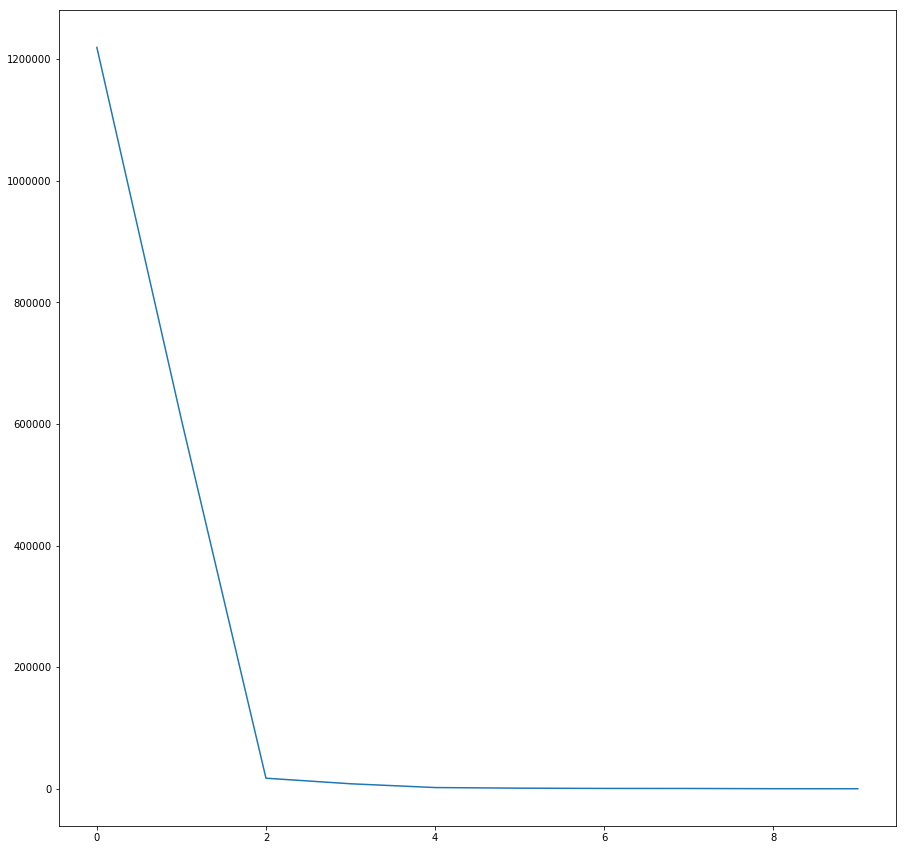

In [19]:
df_avg_na = df_clean.apply(lambda x: x.fillna(x.mean()),axis=0)

plot_component_explained_variance(df_avg_na)
reduced_3d_avg = plot_3d_reduced(df_avg_na)
reduced_2d_avg = plot_2d_reduced(df_avg_na)